<a href="https://colab.research.google.com/github/sameer-kumar-shrivastava/Deep-Learning-Framework-Leveraging-YOLO-v8-for-Facial-Mask-Recognition-in-Computer-Vision/blob/main/Face_Mask_Detection_using_yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing masks, not wearing them, or wearing masks improperly.
This dataset contains 853 images belonging to the 3 classes, as well as their bounding boxes in the PASCAL VOC format.
The classes are:

With mask;
Without mask;
Mask worn incorrectly.

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d andrewmvd/face-mask-detection

100% 397M/398M [00:04<00:00, 47.1MB/s]
100% 398M/398M [00:04<00:00, 86.2MB/s]


In [14]:
# this will extract the all folder in colab
import zipfile
zip_ref = zipfile.ZipFile('/content/face-mask-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [22]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [29]:
annotations_path = "/content/annotations"
images_path = "/content/images"

In [30]:
import glob
import xml.etree.ElementTree as ET

# Initialize an empty dictionary to store the dataset
dataset = {
    "file": [],
    "name": [],
    "width": [],
    "height": [],
    "xmin": [],
    "ymin": [],
    "xmax": [],
    "ymax": [],
}

# Iterate through XML files in a specified directory
for anno in glob.glob(annotations_path + "/*.xml"):
    # Parse the current XML file
    tree = ET.parse(anno)

    # Loop through all elements in the XML tree
    for elem in tree.iter():
        # Check if the current element is for image size
        if 'size' in elem.tag:
            # Loop through the sub-elements within 'size'
            for attr in list(elem):
                # Extract and store image width and height
                if 'width' in attr.tag:
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))

        # Check if the current element is for an object
        if 'object' in elem.tag:
            # Loop through the sub-elements within 'object'
            for attr in list(elem):
                # Extract and store the object name
                if 'name' in attr.tag:
                    name = attr.text
                    dataset['name'] += [name]
                    dataset['width'] += [width]
                    dataset['height'] += [height]
                    # Extract and store the file name (removing the path and extension)
                    dataset['file'] += [anno.split('/')[-1][0:-4]]

                # Check if the current element is for the bounding box
                if 'bndbox' in attr.tag:
                    # Loop through the sub-elements within 'bndbox'
                    for dim in list(attr):
                        # Extract and store bounding box coordinates
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin'] += [xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin'] += [ymin]
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax'] += [xmax]
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax'] += [ymax]

# At this point, the 'dataset' dictionary contains all the extracted data

In [31]:
# create pandas data frame using pandas function
data = pd.DataFrame(dataset)
data

file          name  width  height  xmin  ymin  xmax  ymax
0     maksssksksss541     with_mask    301     400   104   144   213   285
1     maksssksksss363     with_mask    400     197    79    48    97    69
2     maksssksksss363     with_mask    400     197   116    78   134   101
3     maksssksksss363     with_mask    400     197   161    79   179    96
4     maksssksksss363     with_mask    400     197   193    53   209    76
...               ...           ...    ...     ...   ...   ...   ...   ...
4067  maksssksksss302  without_mask    400     226   266    52   278    69
4068  maksssksksss103     with_mask    400     300    42    54    94   110
4069  maksssksksss103     with_mask    400     300   188    46   236   106
4070  maksssksksss103     with_mask    400     300   261    88   303   130
4071  maksssksksss103     with_mask    400     300   368   112   400   151

[4072 rows x 8 columns]

In [32]:
# now encode the names and create class feature
name_dict = {
    'with_mask':0,
    'without_mask':1,
    'mask_weared_incorrect':2

}

data["class"] = data["name"].map(name_dict)

In [33]:
np.sort(data.name.unique()) #classess

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object)

In [34]:
# now split data in to train test
fileNames = [*os.listdir("/content/images")]
print(f'There are {len(fileNames)} images in the dataset')

There are 853 images in the dataset


In [35]:
# now do tranin test split
from sklearn.model_selection import train_test_split
train,test = train_test_split(fileNames,test_size=0.1,random_state=42)
print("Length of Train =",len(train))
print("="*30)
print("Length of test =", len(test))

Length of Train = 767
Length of test = 86


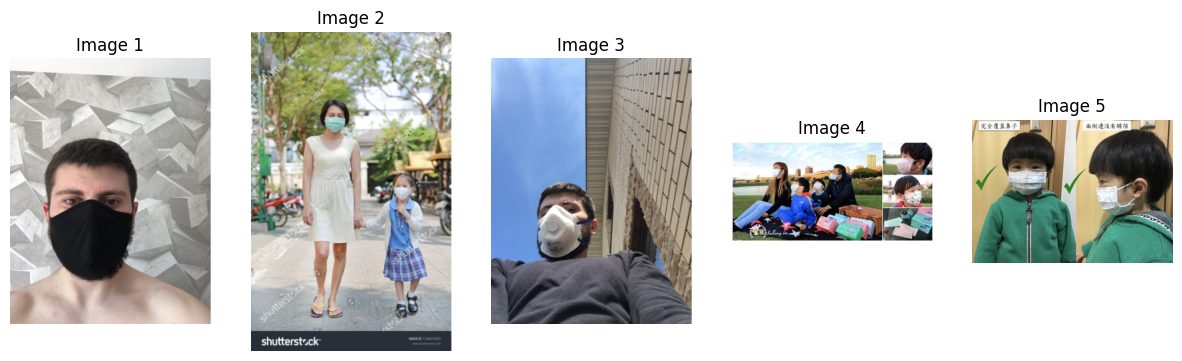

In [36]:
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Directory where your training images are located
data_dir = '/content/images'

# List all files in the directory
image_files = os.listdir(data_dir)

# Select 5 random images
random_images = random.sample(image_files, 5)

# Set up a 2x3 grid for displaying the images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Loop through and display the selected images
for i, image_file in enumerate(random_images):
    image_path = os.path.join(data_dir, image_file)
    image = imread(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')

plt.show()

In [37]:
!pip install ultralytics # run this command and install yolov8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 695.2/695.2 kB 11.2 MB/s eta 0:00:00


In [40]:
# create separate train test dir inside
os.mkdir("/content/data")
os.mkdir("/content/data/train")
os.mkdir("/content/data/test")
os.mkdir('/content/data/train/images')
os.mkdir('/content/data/train/labels')
os.mkdir('/content/data/test/images')
os.mkdir('/content/data/test/labels')

In [41]:
input_data = '/content'
output_data = '/content'

In [42]:
from PIL import Image  # Make sure to import the required module

# Define a function to copy and resize images
def copyImages(imageList, folder_Name):
    for image in imageList:
        # Open the image using PIL (Pillow) from the input_data/images directory
        img = Image.open(input_data + "/images/" + image)

        # Resize the image to a width of 640 pixels and a height of 480 pixels
        img1 = img.resize((640, 480))

        # Save the resized image to the output_datafolder_Name/images directory
        # The 'folder_Name' is provided as an argument to the function
        _ = img1.save(output_data + "/data/" + folder_Name + "/images/" + image)

# Call the function for different sets of images (train, val, test)
copyImages(train, "train")  # Copy and resize images for the 'train' set
copyImages(test, "test")    # Copy and resize images for the 'test' set

In [43]:
# Scale the 'xmax' values based on the width of 640 pixels and the original 'width' values
data['xmax'] = (640 / data['width']) * data['xmax']

# Scale the 'ymax' values based on the height of 480 pixels and the original 'height' values
data['ymax'] = (480 / data['height']) * data['ymax']

# Scale the 'xmin' values based on the width of 640 pixels and the original 'width' values
data['xmin'] = (640 / data['width']) * data['xmin']

# Scale the 'ymin' values based on the height of 480 pixels and the original 'height' values
data['ymin'] = (480 / data['height']) * data['ymin']

In [44]:
# Convert the 'xmax', 'ymax', 'xmin', and 'ymin' columns to integer data type (int64)
data[['xmax', 'ymax', 'xmin', 'ymin']] = data[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

In [45]:
# Calculate the x-center of bounding boxes, normalized by the image width (640 pixels)
data['x_center'] = (data['xmax'] + data['xmin']) / (2 * 640)

# Calculate the y-center of bounding boxes, normalized by the image height (480 pixels)
data['y_center'] = (data['ymax'] + data['ymin']) / (2 * 480)

# Calculate the height of bounding boxes, normalized by the image width (640 pixels)
data['box_height'] = (data['xmax'] - data['xmin']) / 640

# Calculate the width of bounding boxes, normalized by the image height (480 pixels)
data['box_width'] = (data['ymax'] - data['ymin']) / 480

In [46]:
data


file          name  width  height  xmin  ymin  xmax  ymax  \
0     maksssksksss541     with_mask    301     400   221   172   452   342   
1     maksssksksss363     with_mask    400     197   126   116   155   168   
2     maksssksksss363     with_mask    400     197   185   190   214   246   
3     maksssksksss363     with_mask    400     197   257   192   286   233   
4     maksssksksss363     with_mask    400     197   308   129   334   185   
...               ...           ...    ...     ...   ...   ...   ...   ...   
4067  maksssksksss302  without_mask    400     226   425   110   444   146   
4068  maksssksksss103     with_mask    400     300    67    86   150   176   
4069  maksssksksss103     with_mask    400     300   300    73   377   169   
4070  maksssksksss103     with_mask    400     300   417   140   484   208   
4071  maksssksksss103     with_mask    400     300   588   179   640   241   

      class  x_center  y_center  box_height  box_width  
0         0  0.525781  0.535417    0.360938   0.354167  
1         0  0.219531  0.295833    0.045312   0.108333  
2         0  0.311719  0.454167    0.045312   0.116667  
3         0  0.424219  0.442708    0.045312   0.085417  
4         0  0.501563  0.327083    0.040625   0.116667  
...     ...       ...       ...         ...        ...  
4067      1  0.678906  0.266667    0.029687   0.075000  
4068      0  0.169531  0.272917    0.129688   0.187500  
4069      0  0.528906  0.252083    0.120313   0.200000  
4070      0  0.703906  0.362500    0.104688   0.141667  
4071      0  0.959375  0.437500    0.081250   0.129167  

[4072 rows x 13 columns]

In [50]:
# convert in to string
data = data.astype("string")

In [51]:
# Define a function to create label files for YOLO format
def create_labels(image_list, data_name):
    # Extract file names by removing the file extensions
    fileNames = [x.split(".")[0] for x in image_list]

    # Iterate through each image file name
    for name in fileNames:
        # Filter the DataFrame to get data related to the current image
        data_ = data[data.file == name]
        box_list = []  # Initialize a list to store bounding box information

        # Iterate through rows in the filtered data
        for index in range(len(data_)):
            row = data_.iloc[index]

            # Construct a string with YOLO format: class x_center y_center box_height box_width
            box_list.append(
                row['class'] + " " + str(row["x_center"]) + " " + str(row["y_center"]) +
                " " + str(row["box_height"]) + " " + str(row["box_width"])
            )

        # Join the bounding box strings and create a label file for the image
        text = "\n".join(box_list)
        with open(output_data + "/data/" + data_name + "/labels/" + name + ".txt", "w") as file:
            file.write(text)

# Create label files for the 'train', 'val', and 'test' sets
create_labels(train, "train")  # Create labels for the 'train' set
create_labels(test, "test")    # Create labels for the 'test' set

In [53]:
%cat /content/data.yaml

train: /content/data/train/images
val: /content/data/test/images

nc: 3

names: ['with_mask', 'without_mask', 'mask_weared_incorrect']

In [54]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.238 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.4/78.2 GB disk)


In [55]:
from ultralytics import YOLO
from IPython.display import display,Image

In [56]:
# Train YOLOv8 on your custom data use this comand
!yolo task=detect mode=train model=yolov8s.pt data= data.yaml epochs=101 imgsz=416 plots=True

100% 21.5M/21.5M [00:00<00:00, 231MB/s]
Ultralytics YOLOv8.0.238 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=101, time=None, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

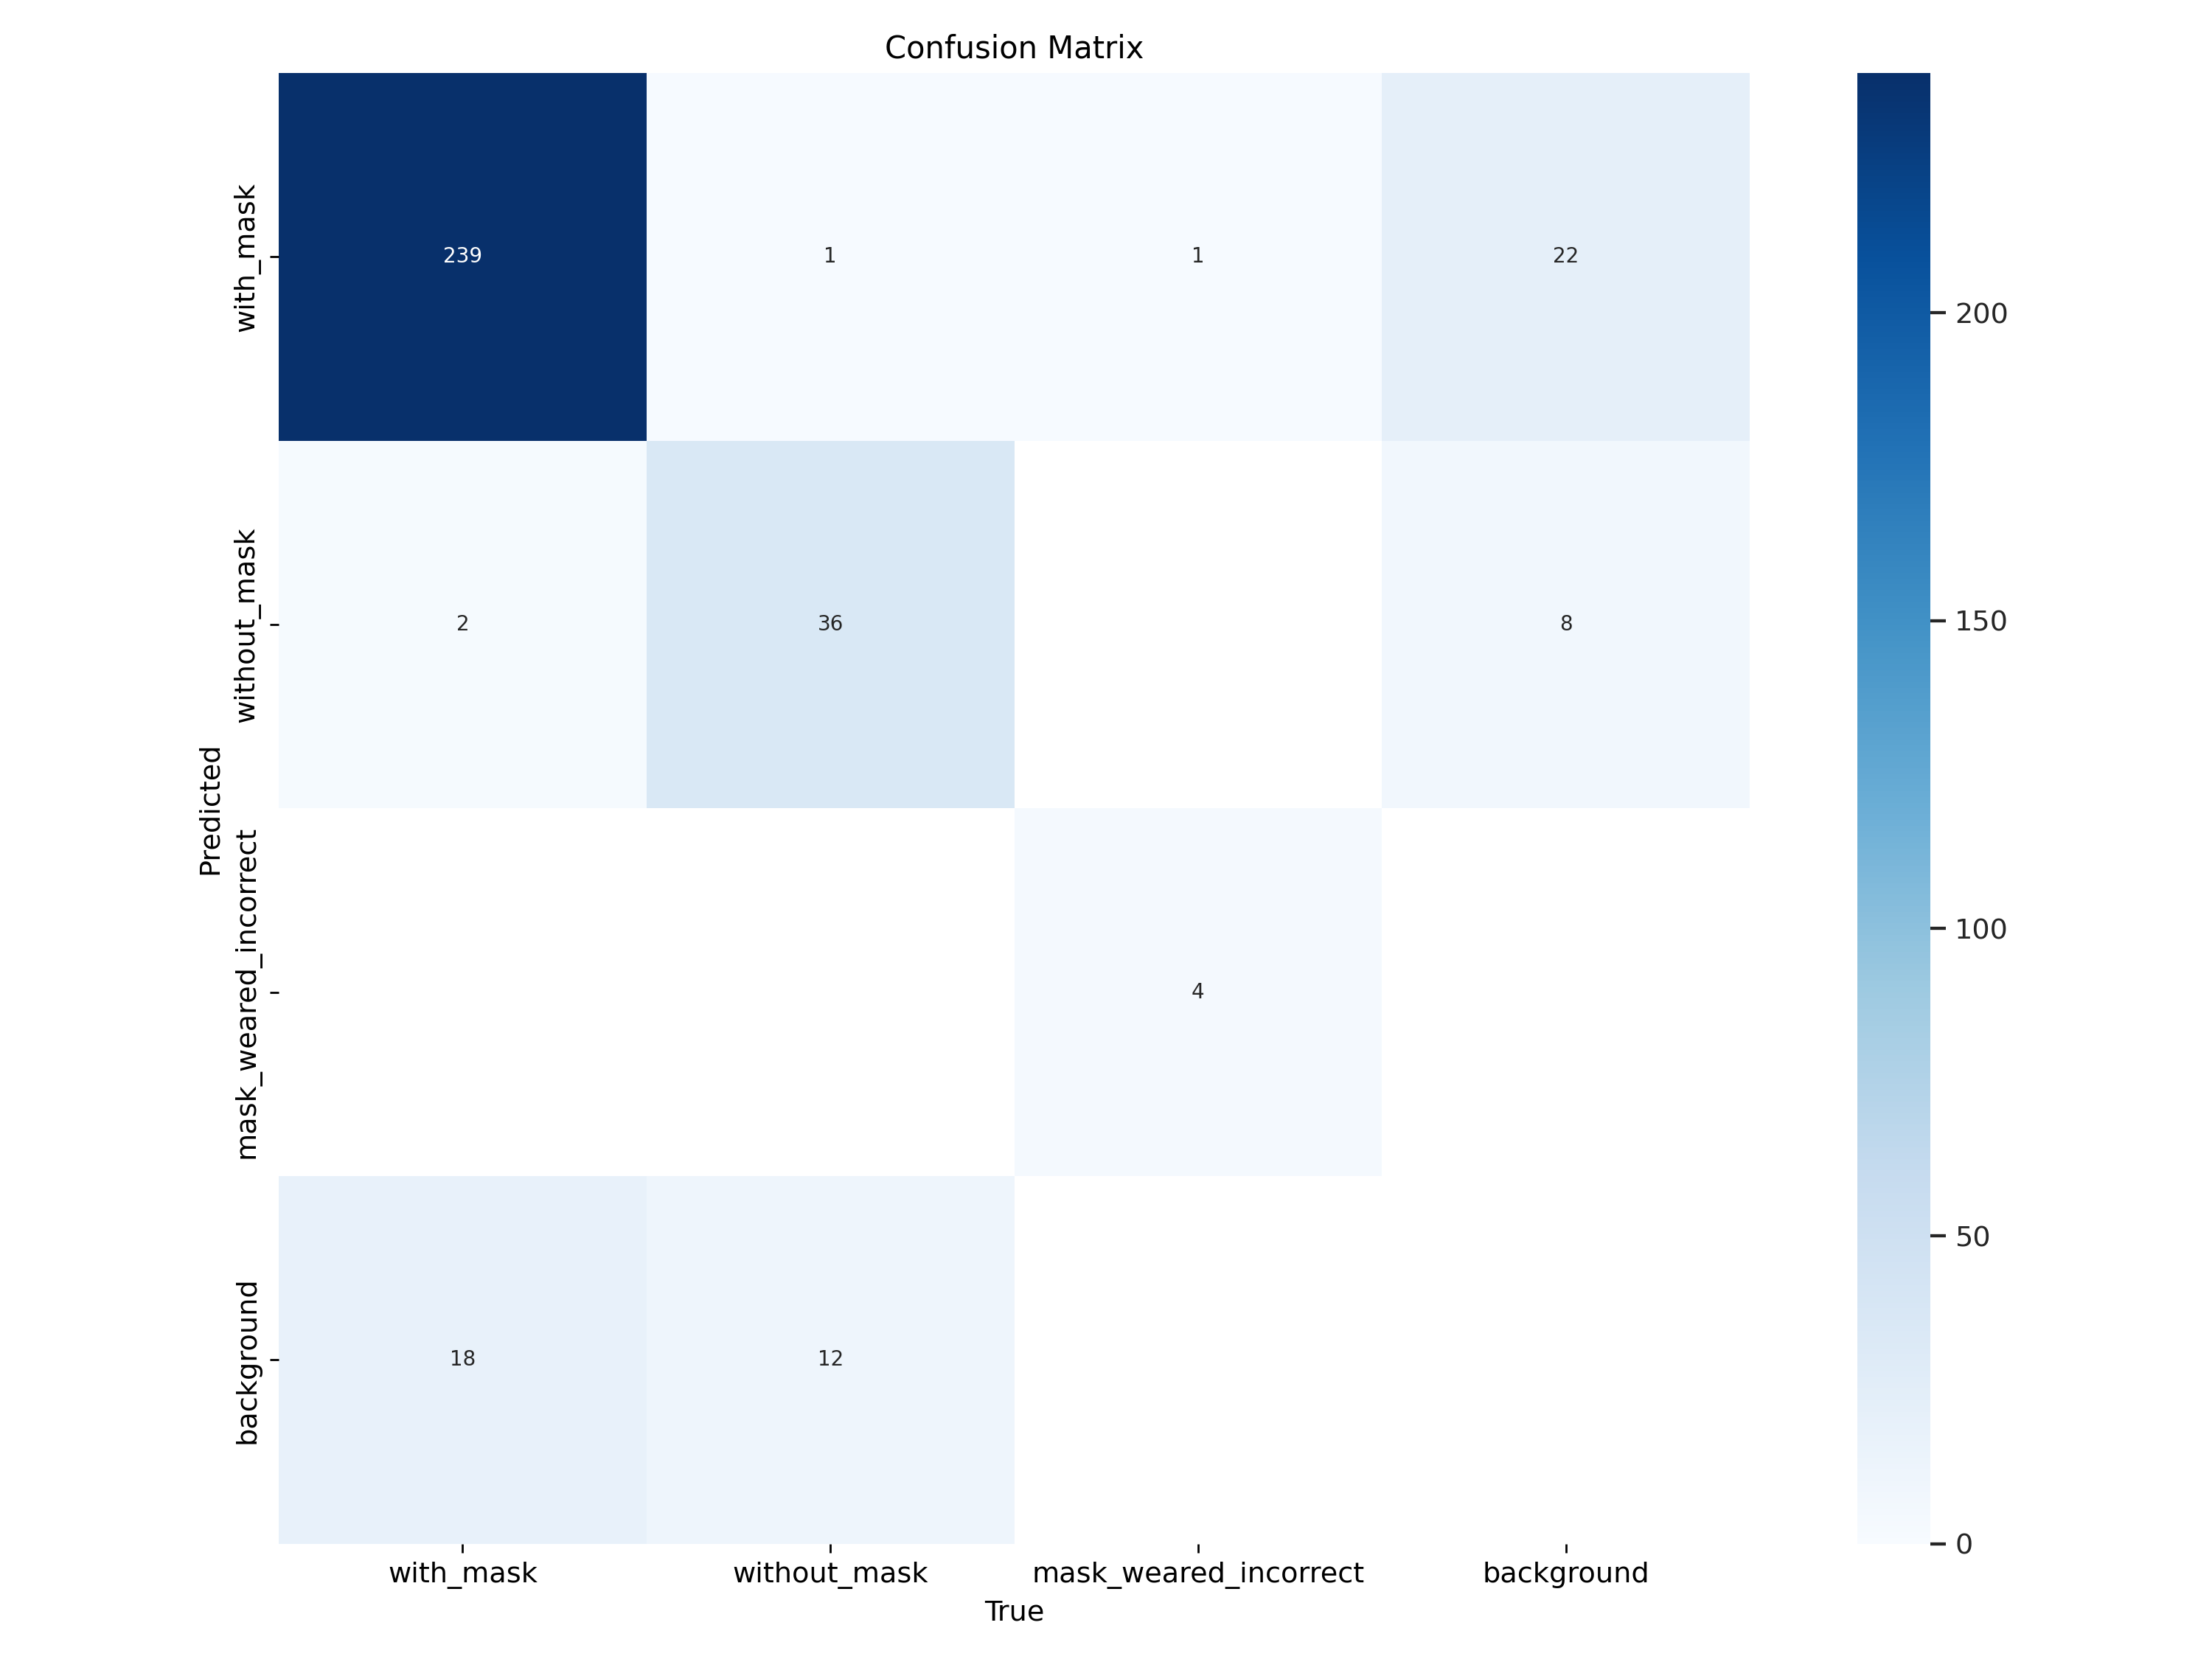

In [58]:
Image(filename="/content/runs/detect/train/confusion_matrix.png",width=600)

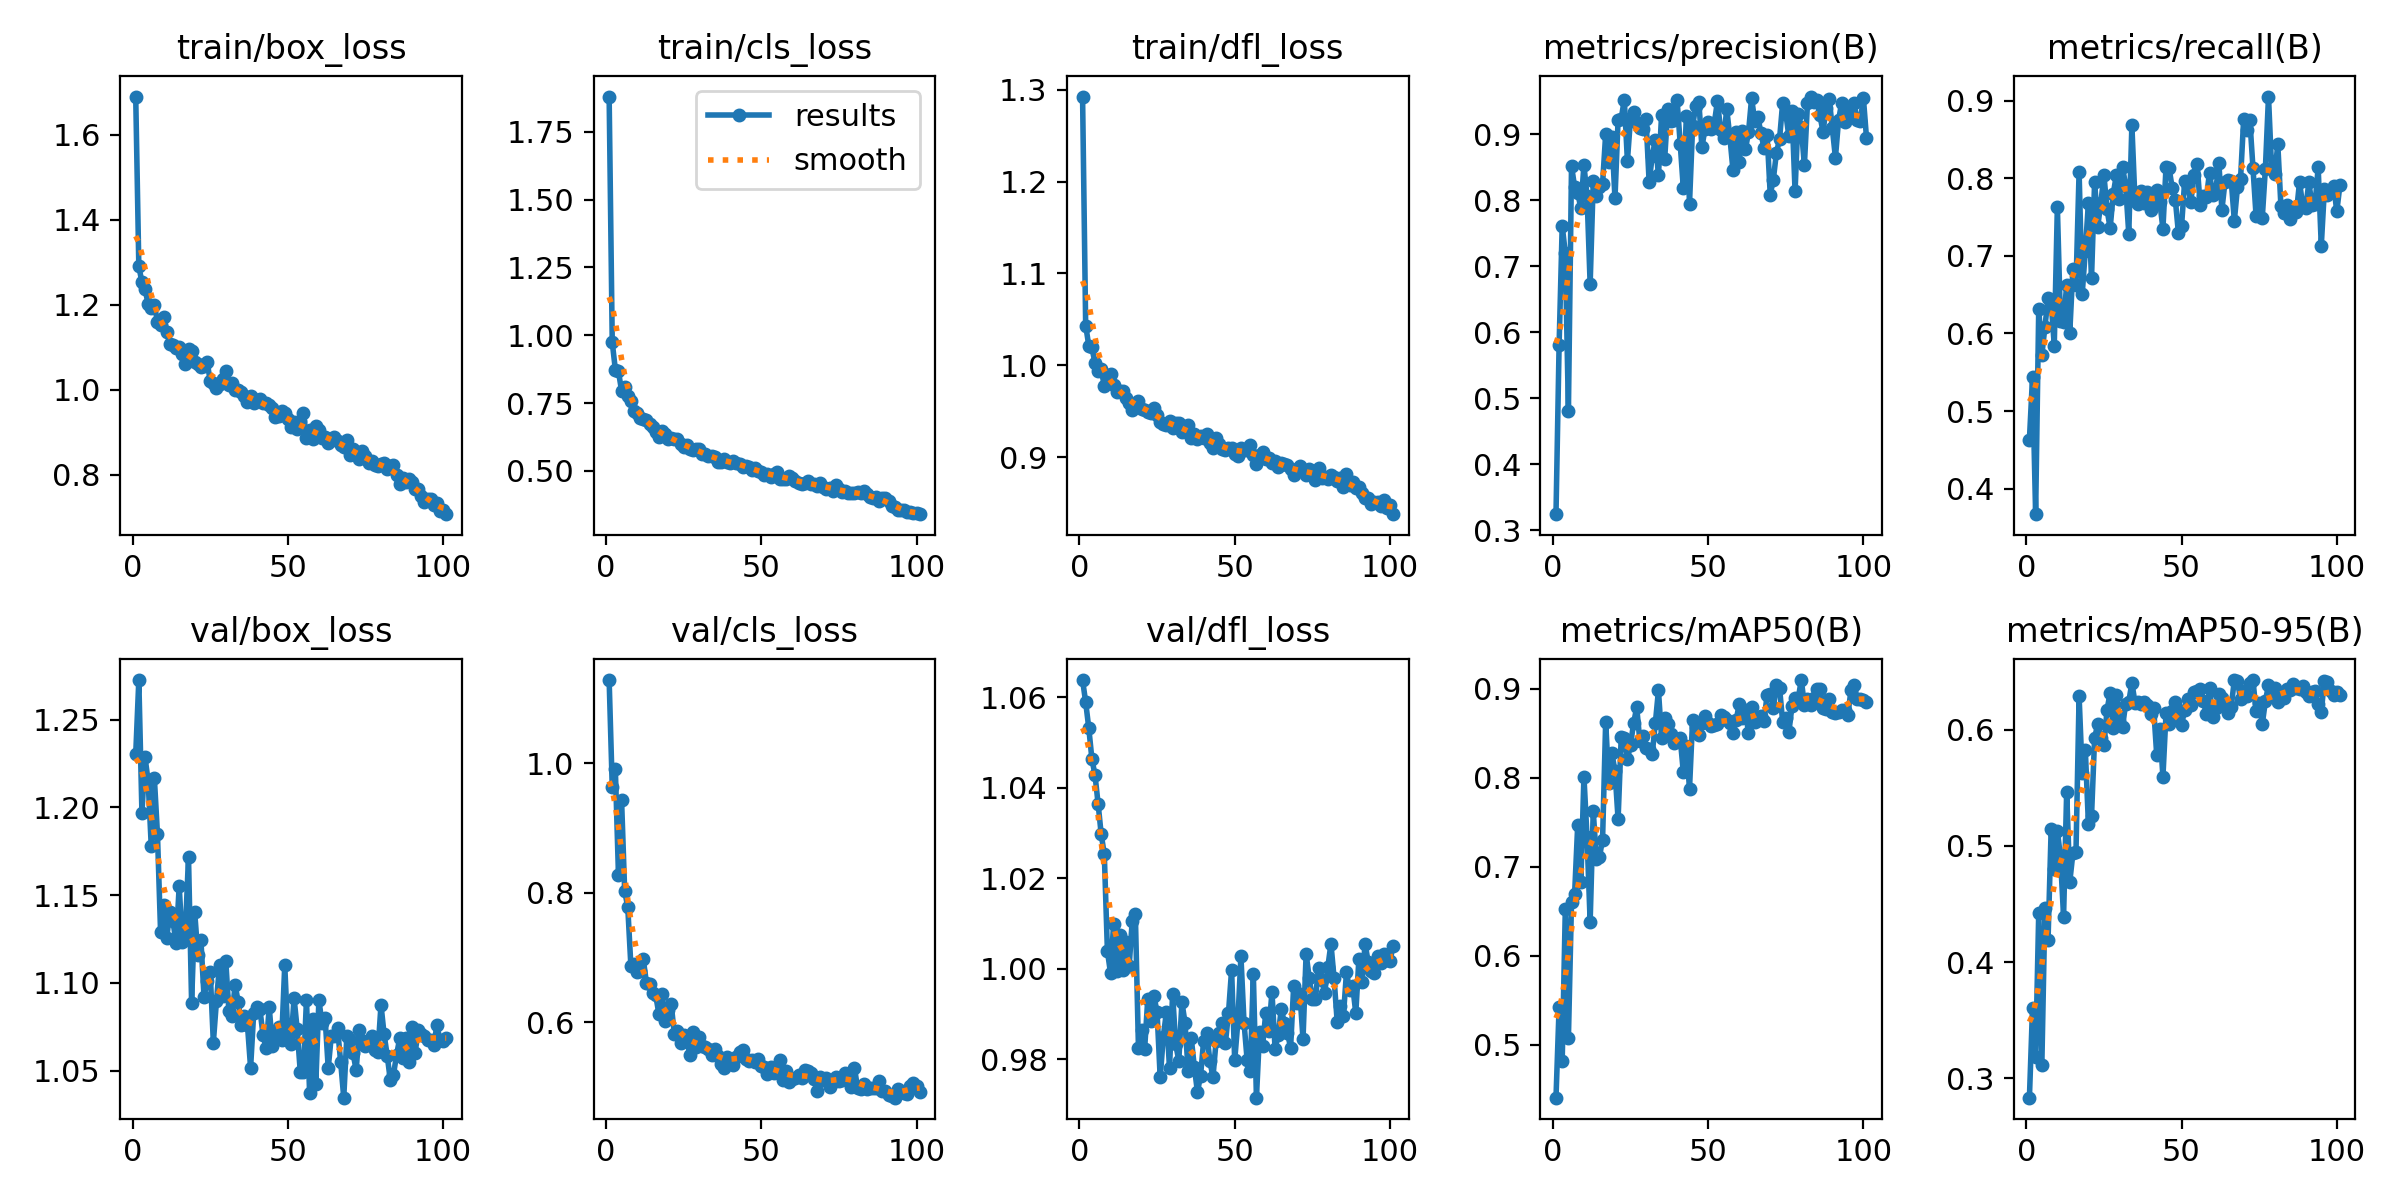

In [59]:
Image(filename="/content/runs/detect/train/results.png",width=600)

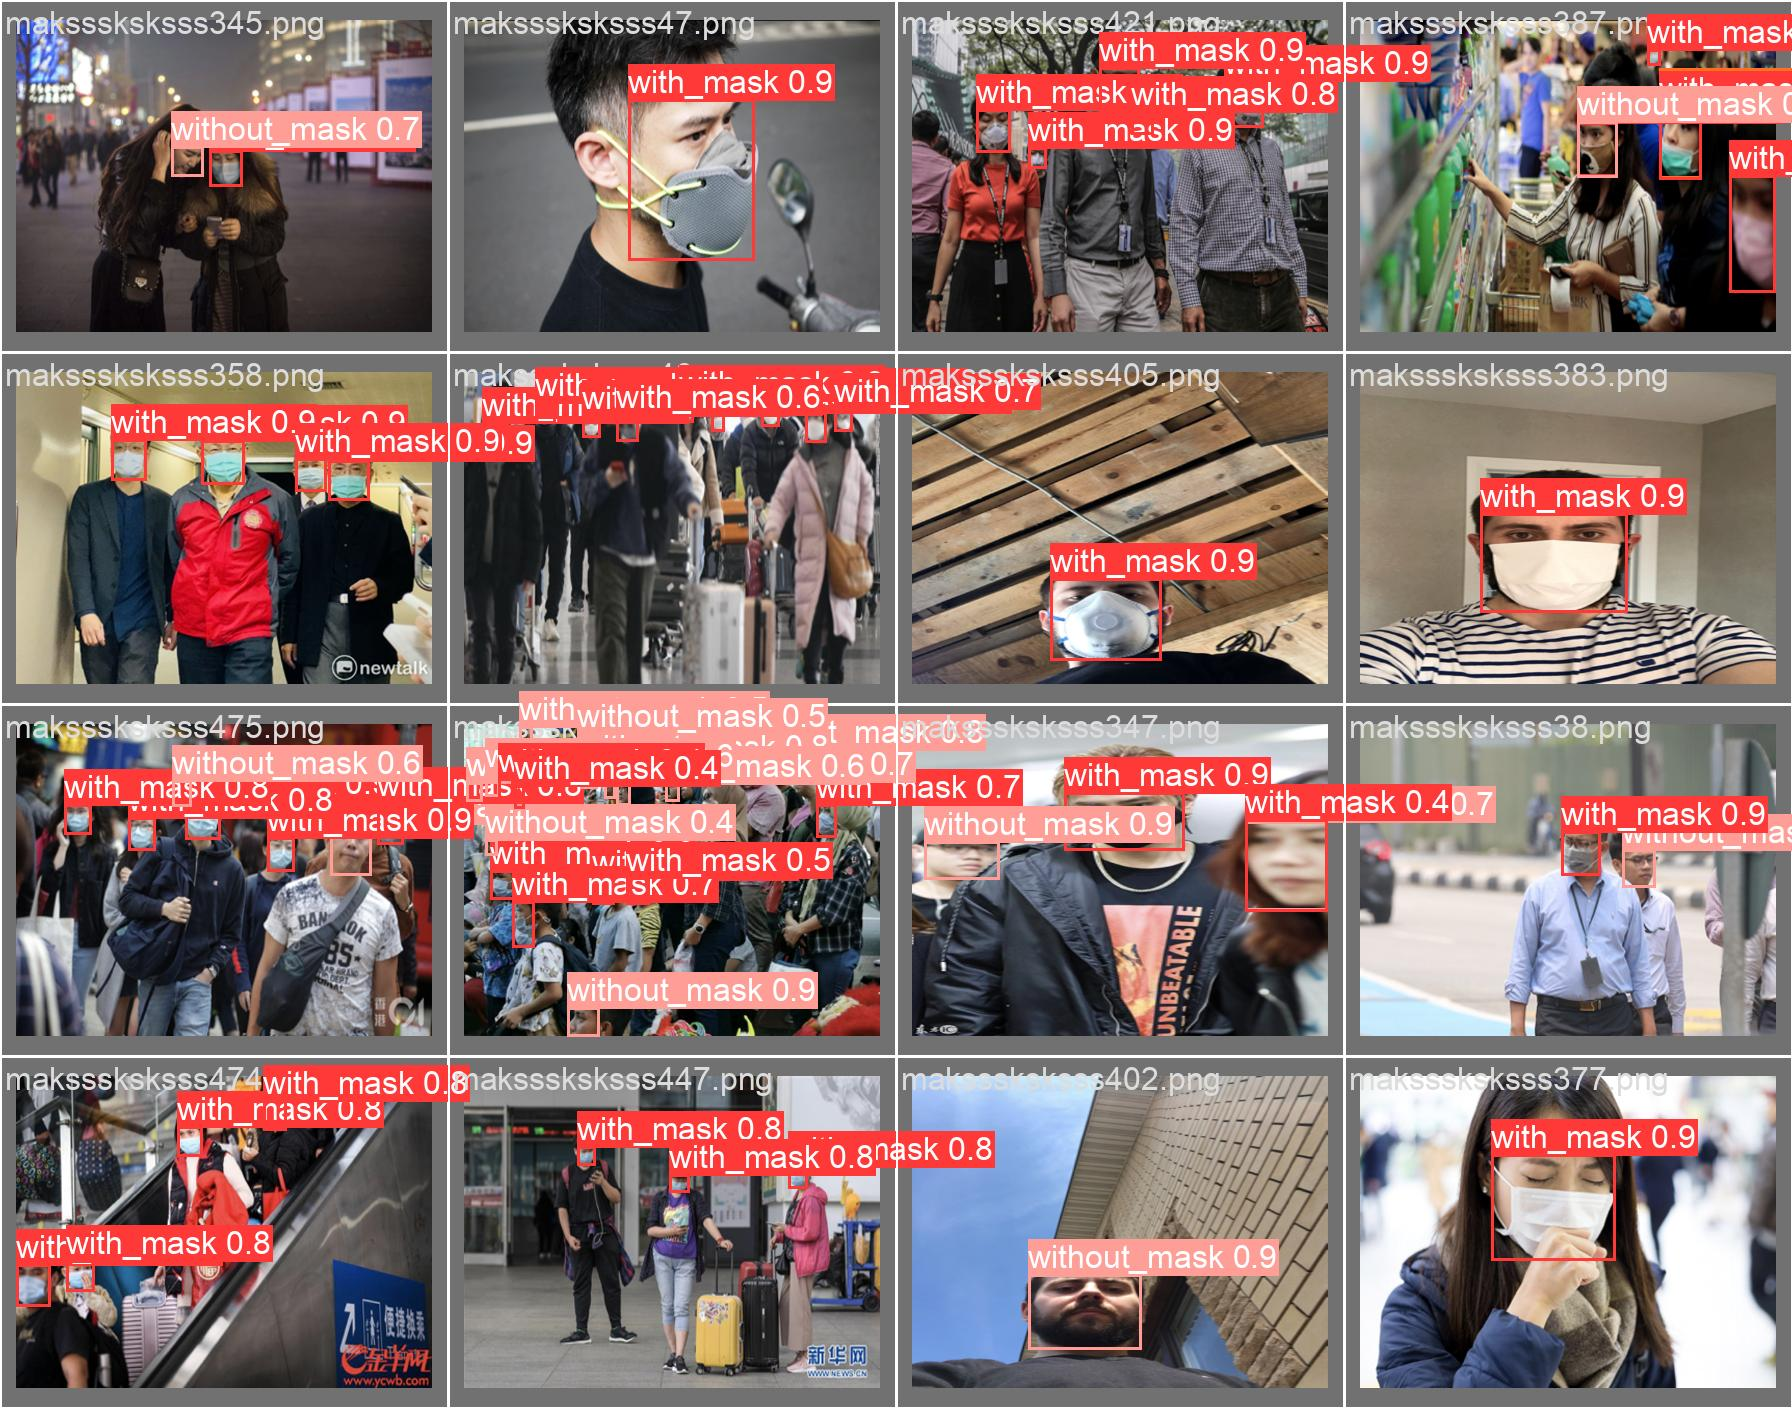

In [60]:
#prediction batchs of yolov8
Image(filename="/content/runs/detect/train/val_batch2_pred.jpg",width=600)

In [61]:
# now validate model
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data= data.yaml

Ultralytics YOLOv8.0.238 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/data/test/labels.cache... 86 images, 0 backgrounds, 0 corrupt: 100% 86/86 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:05<00:00,  1.14it/s]
                   all         86        313      0.893      0.814      0.901      0.641
             with_mask         86        259      0.952      0.911      0.958      0.688
          without_mask         86         49      0.836      0.729      0.808      0.506
 mask_weared_incorrect         86          5       0.89        0.8      0.938      0.728
Speed: 1.2ms preprocess, 18.3ms inference, 0.0ms loss, 14.1ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [63]:
# Inference on the test data and predict
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt data= data.yaml conf=0.50 source=/content/data/test/images

Ultralytics YOLOv8.0.238 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/86 /content/data/test/images/maksssksksss10.png: 320x416 1 with_mask, 225.2ms
image 2/86 /content/data/test/images/maksssksksss102.png: 320x416 2 with_masks, 8.7ms
image 3/86 /content/data/test/images/maksssksksss115.png: 320x416 7 with_masks, 8.5ms
image 4/86 /content/data/test/images/maksssksksss122.png: 320x416 (no detections), 8.5ms
image 5/86 /content/data/test/images/maksssksksss136.png: 320x416 1 with_mask, 10.0ms
image 6/86 /content/data/test/images/maksssksksss148.png: 320x416 2 with_masks, 3 without_masks, 8.5ms
image 7/86 /content/data/test/images/maksssksksss153.png: 320x416 1 with_mask, 1 without_mask, 8.5ms
image 8/86 /content/data/test/images/maksssksksss155.png: 320x416 4 with_masks, 8.5ms
image 9/86 /content/data/test/images/maksssksksss167.png: 320x416

In [65]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt data= data.yaml conf=0.50 source=/content/918a839116b1bdd325d6f8180718be73.jpeg

Ultralytics YOLOv8.0.238 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 466, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 257, in predict
    return self.predictor.predict_cli(source=source) if is_cli else self.predictor(source=source, stream=stream)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/predictor.py", line 207, in predict_cli
    for _ in gen:  # running CLI inference without accumulating any outputs (do not modify)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 35, in generator_context
    response = gen.send(None)
  F

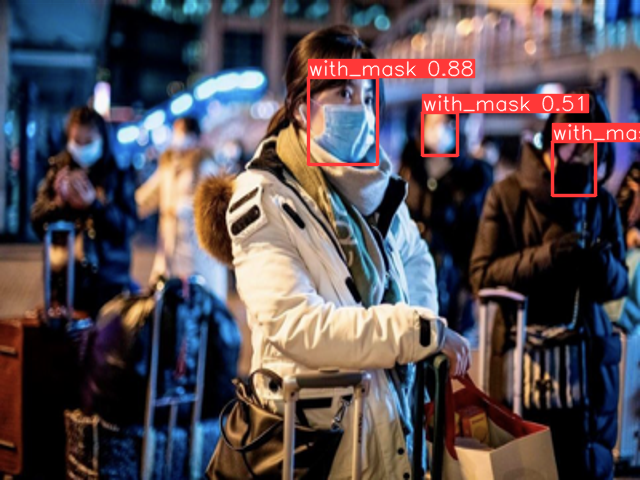

In [67]:
# from PIL import Image
#prediction  of yolov8
Image(filename="/content/runs/detect/predict/maksssksksss98.png",width=600)

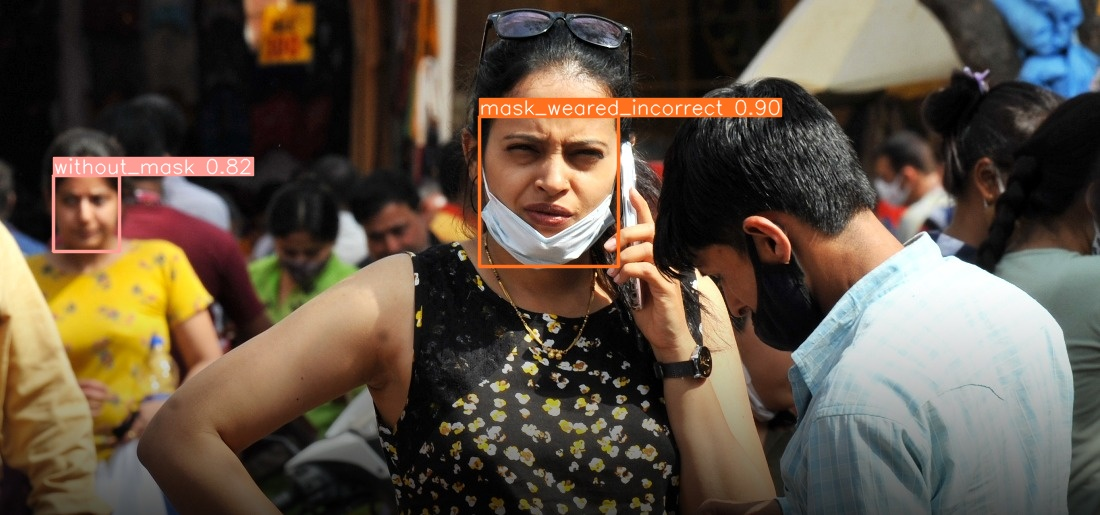

In [ ]:
#prediction  of yolov8
Image(filename="/content/runs/detect/predict2/without-mask-wearing_60d46c60aae23.jpg",width=600)

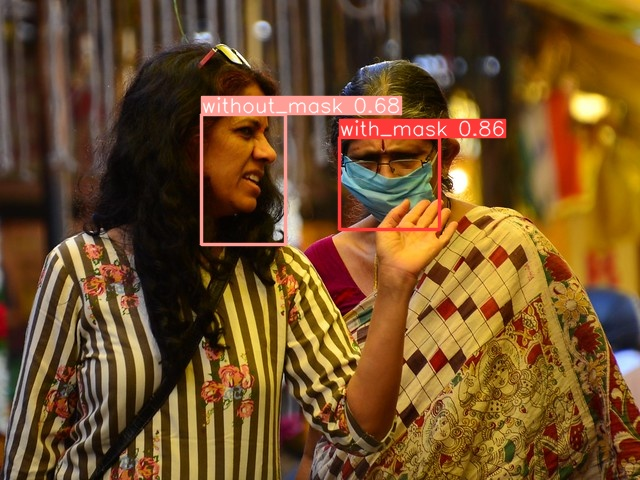

In [ ]:
#prediction  of yolov8
Image(filename="/content/runs/detect/predict3/52625345303_69a0e6784e_z.jpg",width=600)

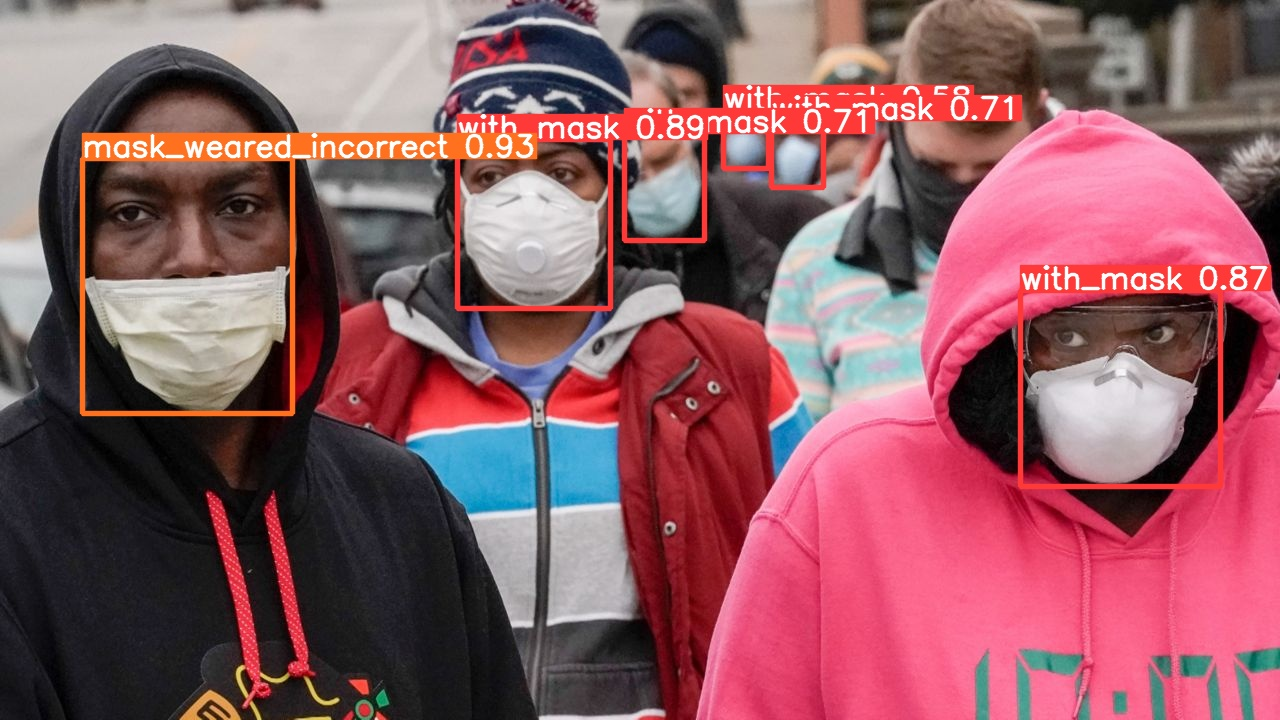

In [ ]:
#prediction  of yolov8
Image(filename="/content/runs/detect/predict4/MASK_1.jpeg",width=600)

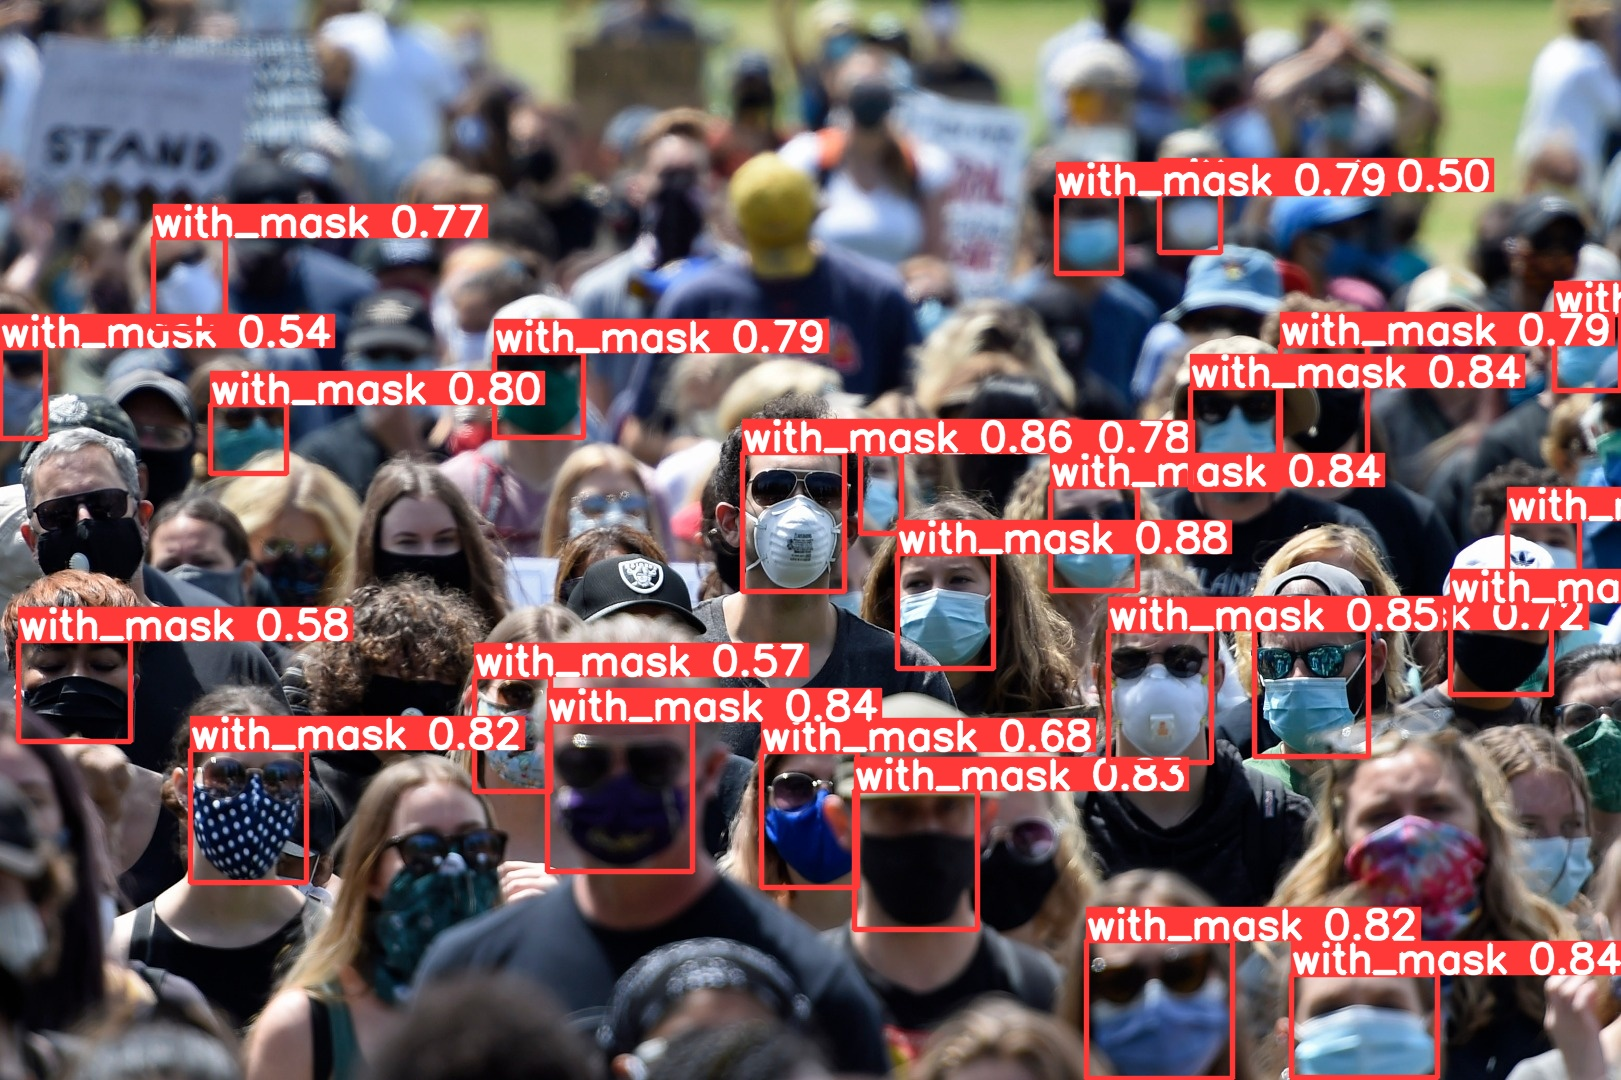

In [ ]:
#prediction  of yolov8
Image(filename="/content/runs/detect/predict5/R.jpeg",width=600)

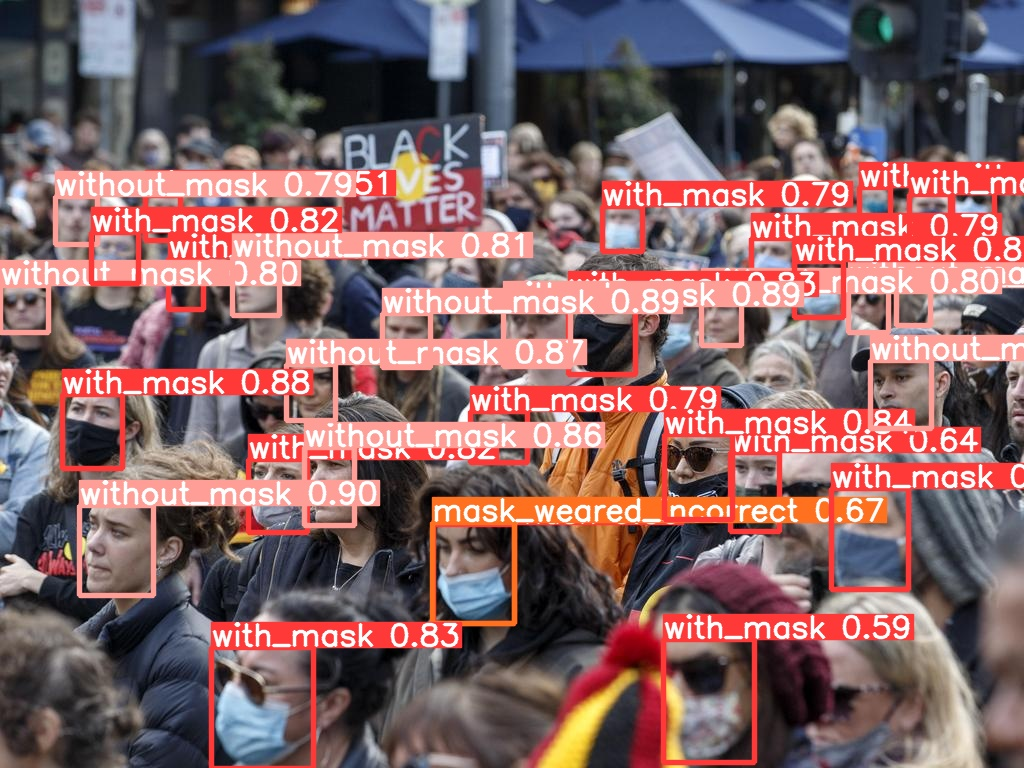

In [ ]:
#prediction  of yolov8
Image(filename="/content/runs/detect/predict6/918a839116b1bdd325d6f8180718be73.jpeg",width=600)